在tf2.0提供了簡便的分佈式計算的方式，`tf.distribute.Strategy`，這次要分別測試單機單卡模擬雙卡以及單機雙卡的效能

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
tf.__version__

'2.0.0'

接著下載MNIST資料集

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

取得資料之後都一定要先確認相關維度資訊，而不是直接使用

In [5]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [6]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

這邊我們並沒有特別將label的部份轉one hot encoder

In [7]:
y_test[0]

7

因為影像本身為灰階，因此需要外推一個軸出去，讓它變為28x28x1才能符合模型訓練維度，這有兩種作法，`np.reshape`或`np.expand_dims`

In [8]:
x_train = np.expand_dims(x_train, 3)

In [9]:
x_train.shape

(60000, 28, 28, 1)

In [10]:
x_test = x_test.reshape(10000, 28, 28, 1)

In [11]:
x_test.shape

(10000, 28, 28, 1)

接下來要對資料做大小標準化，提高訓練效率

In [12]:
x_train = x_train / 255.
x_test = x_test / 255.

可以先簡單確認，圖像的大小為28x28，而且是灰階圖。

簡單列印幾張照片來確認

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

隨機取得10個索引

In [14]:
index = np.random.randint(0, 60000, size=10)
index

array([36209, 46725, 57823, 28816, 20957, 59126, 32445,  3889, 34225,
       52818])

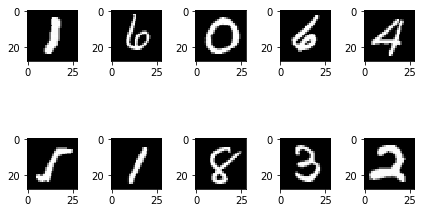

In [15]:
i = 0
for idx in index:
    plt.subplot(str(25)+str(i))    
    plt.imshow(x_train[idx][:, :, 0], cmap='gray')
    i += 1

plt.tight_layout()
plt.show()

確認我們所擁有的硬體資源

In [16]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

In [17]:
gpus 

[PhysicalDevice(name=u'/physical_device:GPU:0', device_type=u'GPU'),
 PhysicalDevice(name=u'/physical_device:GPU:1', device_type=u'GPU')]

設置單卡模擬，下面將`GPU:0`的顯卡模擬為兩塊帶4g記憶體的顯卡

In [18]:
tf.config.experimental.set_virtual_device_configuration(
    gpus[1],
    [
        tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120),
        tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)
    ]
)

接著利用`tf.config.experimental.list_logical_devices`來確認

In [19]:
gpus = tf.config.experimental.list_logical_devices(device_type='GPU')

In [20]:
gpus = gpus[:2] 
gpus

[LogicalDevice(name='/job:localhost/replica:0/task:0/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/job:localhost/replica:0/task:0/device:GPU:1', device_type='GPU')]

一樣利用`MirroredStrategy`來做單機單卡模擬雙卡訓練

首先new一個MirroredStrategy object

In [21]:
strategy = tf.distribute.MirroredStrategy(devices=[gpu.name for gpu in gpus])

然後將模型建構的部份放置於`strategy.scope()`的上下文中

In [22]:
with strategy.scope():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), padding='valid', activation='tanh'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='tanh'),
        tf.keras.layers.Dense(84, activation='tanh'),
        tf.keras.layers.Dense(10, activation='softmax'),
    ])
    # compile的部份也要
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
    )


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


也可以在實例化的過程中指定硬體資源：  
```python
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
```

確認模型

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [24]:
model.fit(x_train, 
          y_train, 
          batch_size=32,
          epochs=3)

Train on 60000 samples
Epoch 1/3
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

嗯...這中間應該有那裡有誤會，後續應該還可以再研究一下，因為最後是以CPU在訓練，似乎無法虛擬顯卡處理?